In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 21.5 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import torch
import pytorch_lightning as pl
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms, AutoAugment, AutoAugmentPolicy
import torch.nn.functional as F
from torch.optim import AdamW, lr_scheduler
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torchvision


In [ ]:
__file__ = "vit.py"
BASE_DIR = Path(__file__).parent.parent

In [ ]:
BASE_DIR = Path(__file__).parent.parent

In [ ]:
batch_size = 32
sequence_size = 64
hidden_size = 512
num_heads = 8

In [ ]:
#debug this
class PatchifyTransform:
  def __init__(self,patch_size):
    self.patch_size = patch_size

  def __call__(self, img: torch.Tensor):
    res = img.unfold(1,self.patch_size , self.patch_size)
    res = res.unfold(2,self.patch_size , self.patch_size)
    return res.reshape(-1, self.patch_size * self.patch_size * 3)

In [ ]:
class CIFAR10DataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int, patch_size: int = 4, val_batch_size: int = 16,im_size: int = 32, rotation_degrees:(int,int)=(-30,30)):
        super().__init__()

        self.batch_size = batch_size
        self.val_batch_size = val_batch_size
        self.train_transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(size=(im_size, im_size)),
                transforms.RandomRotation(degrees=rotation_degrees),
                AutoAugment(AutoAugmentPolicy.CIFAR10),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                PatchifyTransform(patch_size)
            ]
        )
        self.val_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                PatchifyTransform(patch_size)
            ]
        )
        self.patch_size = patch_size
        self.ds_train = None
        self.ds_val = None

    def prepare_data(self) -> None:
        CIFAR10(BASE_DIR.joinpath('data/cifar'), train=True, transform=self.train_transform, download=True)
        CIFAR10(BASE_DIR.joinpath('data/cifar'), train=False, transform=self.val_transform, download=True)

    def setup(self, stage: str) -> None:
        self.ds_train = CIFAR10(BASE_DIR.joinpath('data/cifar'), train=True, transform=self.train_transform)
        self.ds_val = CIFAR10(BASE_DIR.joinpath('data/cifar'), train=False, transform=self.val_transform)

    def train_dataloader(self):
        # Due to small dataset we don't need to use multiprocessing
        return DataLoader(self.ds_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.val_batch_size)

    @property
    def classes(self):
        return 10  # CIFAR10 has 10 possible classes

In [ ]:
class ImageEmbedding(nn.Module):

  def __init__(self,size:int,hidden_size:int,num_patches:int,dropout:float=0.2):
     super().__init__()

     self.projection=nn.Linear(size,hidden_size)

     #tensor created through nn.Parameter() are added to graph and trained
     self.class_token=nn.Parameter(torch.rand(1,hidden_size))

     self.position=nn.Parameter(torch.rand(1,num_patches+1,hidden_size))
     self.dropout = nn.Dropout(dropout)

  def forward(self, inp:torch.Tensor):

    res = self.projection(inp)

    class_token=self.class_token.repeat(res.size(0),1,1)

    res = torch.concat([class_token,res],dim=1)

    position = self.position.repeat(res.size(0),1,1)

    return self.dropout(res+position)



In [ ]:
class AttentionHead(nn.Module):

    def __init__(self, size: int): # size is hidden size
        super(AttentionHead, self).__init__()

        self.query = nn.Linear(size, size)
        self.key = nn.Linear(size, size)
        self.value = nn.Linear(size, size)

    def forward(self, input_tensor: torch.Tensor):
        q, k, v = self.query(input_tensor), self.key(input_tensor), self.value(input_tensor)

        scale = q.size(1) ** 0.5
        scores = torch.bmm(q, k.transpose(1, 2)) / scale

        scores = F.softmax(scores, dim=-1)

        # 8 x 64 x 64 @ 8 x 64 x 48 = 8 x 64 x 48
        output = torch.bmm(scores, v)
        return output

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, size: int, num_heads: int):
        super().__init__()

        self.heads = nn.ModuleList([AttentionHead(size) for _ in range(num_heads)])
        self.linear = nn.Linear(size * num_heads, size)

    def forward(self, input_tensor: torch.Tensor):
        s = [head(input_tensor) for head in self.heads]
        s = torch.cat(s, dim=-1)

        output = self.linear(s)
        return output


In [ ]:
class Encoder(nn.Module):

    def __init__(self, size: int, num_heads: int, dropout: float = 0.1):
        super().__init__()

        self.attention = MultiHeadAttention(size, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(size, 4 * size),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(4 * size, size),
            nn.Dropout(dropout)
        )
        self.norm_attention = nn.LayerNorm(size)
        self.norm_feed_forward = nn.LayerNorm(size)

    def forward(self, input_tensor):
        attn = input_tensor + self.attention(self.norm_attention(input_tensor))
        output = attn + self.feed_forward(self.norm_feed_forward(attn))
        return output

In [ ]:

def logit_accuracy(logits: torch.Tensor, target: torch.Tensor) -> float:
    idx = logits.max(1).indices
    acc = (idx == target).int()
    return acc.sum() / torch.numel(acc)

In [ ]:
class ViT(pl.LightningModule):
    def __init__(self, size: int, hidden_size: int, num_patches: int, num_classes: int, num_heads: int,
                 num_encoders: int, emb_dropout: float = 0.1, dropout: float = 0.1,
                 lr: float = 1e-4, min_lr: float = 4e-5,
                 weight_decay: float = 0.1, epochs: int = 200):
        super().__init__()
        self.save_hyperparameters()

        self.lr = lr
        self.min_lr = min_lr
        self.weight_decay = weight_decay
        self.epochs = epochs

        self.embedding = ImageEmbedding(size, hidden_size, num_patches, dropout=emb_dropout)

        self.encoders = nn.Sequential(
            *[Encoder(hidden_size, num_heads, dropout=dropout) for _ in range(num_encoders)],
        )
        self.mlp_head = nn.Linear(hidden_size, num_classes)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        emb = self.embedding(input_tensor)
        attn = self.encoders(emb)

        return self.mlp_head(attn[:, 0, :])

    def training_step(self, batch, batch_idx):
        input_batch, target = batch

        logits = self(input_batch)
        loss = F.cross_entropy(logits, target)

        if batch_idx % 5 == 0:
            self.log("train_acc", logit_accuracy(logits, target), prog_bar=True)

        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):

        input_batch, target = batch
        output = self(input_batch)

        loss = F.cross_entropy(output, target)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", logit_accuracy(output, target), prog_bar=True)

        return loss

    def configure_optimizers(self):

        optimizer = AdamW(self.configure_parameters(), lr=self.lr)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, self.epochs, eta_min=self.min_lr)

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def configure_parameters(self):
        no_decay_modules = (nn.LayerNorm,)
        decay_modules = (nn.Linear,)

        decay = set()
        no_decay = set()

        # this, of course, makes training (loss reduction) slower
        for module_name, module in self.named_modules():
            if module is self:
                continue
            for param_name, value in module.named_parameters():
                full_name = f"{module_name}.{param_name}" if module_name else param_name
                if param_name.endswith('bias'):
                    no_decay.add(full_name)
                elif param_name.endswith('weight') and isinstance(module, no_decay_modules):
                    no_decay.add(full_name)
                elif param_name.endswith('weight') and isinstance(module, decay_modules):
                    decay.add(full_name)

        optim_groups = [
            {"params": [v for name, v in self.named_parameters() if name in decay],
             "weight_decay": self.weight_decay},
            {"params": [v for name, v in self.named_parameters() if name in no_decay],
             "weight_decay": 0}
        ]
        return optim_groups

In [ ]:
LOG_EVERY_N_STEPS = 50
MAX_EPOCHS = 200

BATCH_SIZE = 128
VAL_BATCH_SIZE = 128
PATCH_SIZE = 4

SIZE = PATCH_SIZE * PATCH_SIZE * 3
HIDDEN_SIZE = 512
NUM_PATCHES = int(32 * 32 / PATCH_SIZE ** 2)  # 32 x 32 is the size of image in CIFAR10

NUM_HEADS = 8
NUM_ENCODERS = 6

DROPOUT = 0.1
EMB_DROPOUT = 0.1

LEARNING_RATE = 1e-4
MIN_LEARNING_RATE = 2.5e-5
WEIGHT_DECAY = 1e-6

In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
data = CIFAR10DataModule(batch_size=BATCH_SIZE, patch_size=PATCH_SIZE)

model = ViT(
    size=SIZE,
    hidden_size=HIDDEN_SIZE,
    num_patches=NUM_PATCHES,
    num_classes=data.classes,
    num_heads=NUM_HEADS,
    num_encoders=NUM_ENCODERS,
    emb_dropout=EMB_DROPOUT,
    dropout=DROPOUT,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    epochs=MAX_EPOCHS
)

In [ ]:
LIGHTNING_DIR = BASE_DIR.joinpath("data/lightning")
MODELS_DIR = LIGHTNING_DIR.joinpath("models")

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath=MODELS_DIR,
    monitor="val_loss",
    save_last=True,
    verbose=True
)
es = EarlyStopping(monitor="val_loss", mode="min", patience=10)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [ ]:
    es = EarlyStopping(monitor="val_loss", mode="min", patience=16)
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    trainer = pl.Trainer(
        accelerator="cuda",
        default_root_dir=LIGHTNING_DIR,
        log_every_n_steps=LOG_EVERY_N_STEPS,
        max_epochs=MAX_EPOCHS,
        callbacks=[checkpoint_callback, es, lr_monitor])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,data)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | embedding | ImageEmbedding | 58.9 K
1 | encoders  | Sequential     | 63.0 M
2 | mlp_head  | Linear         | 5.1 K 
---------------------------------------------
63.1 M    Trainable params
0         Non-trainable params
63.1 M    Total params
252.332   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 391: 'val_loss' reached 1.75881 (best 1.75881), saving model to '/content/data/lightning/models/epoch=0-step=391.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 782: 'val_loss' reached 1.69536 (best 1.69536), saving model to '/content/data/lightning/models/epoch=1-step=782.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1173: 'val_loss' reached 1.65212 (best 1.65212), saving model to '/content/data/lightning/models/epoch=2-step=1173.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1564: 'val_loss' reached 1.63913 (best 1.63913), saving model to '/content/data/lightning/models/epoch=3-step=1564.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1955: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2346: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2737: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3128: 'val_loss' reached 1.56805 (best 1.56805), saving model to '/content/data/lightning/models/epoch=7-step=3128.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3519: 'val_loss' reached 1.54431 (best 1.54431), saving model to '/content/data/lightning/models/epoch=8-step=3519.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3910: 'val_loss' reached 1.51954 (best 1.51954), saving model to '/content/data/lightning/models/epoch=9-step=3910.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 4301: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 4692: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 5083: 'val_loss' reached 1.50255 (best 1.50255), saving model to '/content/data/lightning/models/epoch=12-step=5083.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 5474: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 5865: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 6256: 'val_loss' reached 1.46264 (best 1.46264), saving model to '/content/data/lightning/models/epoch=15-step=6256.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 6647: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 7038: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 7429: 'val_loss' reached 1.44033 (best 1.44033), saving model to '/content/data/lightning/models/epoch=18-step=7429.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 7820: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 8211: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 8602: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 8993: 'val_loss' reached 1.40352 (best 1.40352), saving model to '/content/data/lightning/models/epoch=22-step=8993.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 9384: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 9775: 'val_loss' reached 1.37426 (best 1.37426), saving model to '/content/data/lightning/models/epoch=24-step=9775.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 10166: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 10557: 'val_loss' reached 1.34344 (best 1.34344), saving model to '/content/data/lightning/models/epoch=26-step=10557.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 10948: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 11339: 'val_loss' reached 1.32671 (best 1.32671), saving model to '/content/data/lightning/models/epoch=28-step=11339.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 11730: 'val_loss' reached 1.31423 (best 1.31423), saving model to '/content/data/lightning/models/epoch=29-step=11730.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 12121: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 12512: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 12903: 'val_loss' reached 1.28141 (best 1.28141), saving model to '/content/data/lightning/models/epoch=32-step=12903.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 13294: 'val_loss' reached 1.25921 (best 1.25921), saving model to '/content/data/lightning/models/epoch=33-step=13294.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 13685: 'val_loss' reached 1.24215 (best 1.24215), saving model to '/content/data/lightning/models/epoch=34-step=13685.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 14076: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 14467: 'val_loss' reached 1.20805 (best 1.20805), saving model to '/content/data/lightning/models/epoch=36-step=14467.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 14858: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 15249: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 15640: 'val_loss' reached 1.18915 (best 1.18915), saving model to '/content/data/lightning/models/epoch=39-step=15640.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 16031: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 16422: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 16813: 'val_loss' reached 1.17026 (best 1.17026), saving model to '/content/data/lightning/models/epoch=42-step=16813.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 17204: 'val_loss' reached 1.12451 (best 1.12451), saving model to '/content/data/lightning/models/epoch=43-step=17204.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 17595: 'val_loss' reached 1.11175 (best 1.11175), saving model to '/content/data/lightning/models/epoch=44-step=17595.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 17986: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 18377: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 18768: 'val_loss' reached 1.08941 (best 1.08941), saving model to '/content/data/lightning/models/epoch=47-step=18768.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 19159: 'val_loss' reached 1.04756 (best 1.04756), saving model to '/content/data/lightning/models/epoch=48-step=19159.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 19550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 19941: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 20332: 'val_loss' reached 1.03668 (best 1.03668), saving model to '/content/data/lightning/models/epoch=51-step=20332.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 20723: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 21114: 'val_loss' reached 1.02592 (best 1.02592), saving model to '/content/data/lightning/models/epoch=53-step=21114.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 21505: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 21896: 'val_loss' reached 0.97439 (best 0.97439), saving model to '/content/data/lightning/models/epoch=55-step=21896.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 22287: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 22678: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 23069: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 23460: 'val_loss' reached 0.93946 (best 0.93946), saving model to '/content/data/lightning/models/epoch=59-step=23460.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 23851: 'val_loss' reached 0.93333 (best 0.93333), saving model to '/content/data/lightning/models/epoch=60-step=23851.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 24242: 'val_loss' reached 0.93205 (best 0.93205), saving model to '/content/data/lightning/models/epoch=61-step=24242.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 24633: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 25024: 'val_loss' reached 0.91001 (best 0.91001), saving model to '/content/data/lightning/models/epoch=63-step=25024.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 25415: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 25806: 'val_loss' reached 0.89059 (best 0.89059), saving model to '/content/data/lightning/models/epoch=65-step=25806.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 26197: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 26588: 'val_loss' reached 0.88288 (best 0.88288), saving model to '/content/data/lightning/models/epoch=67-step=26588.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 26979: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 27370: 'val_loss' reached 0.86224 (best 0.86224), saving model to '/content/data/lightning/models/epoch=69-step=27370.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 27761: 'val_loss' reached 0.85757 (best 0.85757), saving model to '/content/data/lightning/models/epoch=70-step=27761.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 28152: 'val_loss' reached 0.85299 (best 0.85299), saving model to '/content/data/lightning/models/epoch=71-step=28152.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 28543: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 28934: 'val_loss' reached 0.85204 (best 0.85204), saving model to '/content/data/lightning/models/epoch=73-step=28934.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 29325: 'val_loss' reached 0.84547 (best 0.84547), saving model to '/content/data/lightning/models/epoch=74-step=29325.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 29716: 'val_loss' reached 0.83711 (best 0.83711), saving model to '/content/data/lightning/models/epoch=75-step=29716.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 30107: 'val_loss' reached 0.82931 (best 0.82931), saving model to '/content/data/lightning/models/epoch=76-step=30107.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 30498: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 30889: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 31280: 'val_loss' reached 0.80198 (best 0.80198), saving model to '/content/data/lightning/models/epoch=79-step=31280.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 31671: 'val_loss' reached 0.79081 (best 0.79081), saving model to '/content/data/lightning/models/epoch=80-step=31671.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 32062: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 32453: 'val_loss' reached 0.77866 (best 0.77866), saving model to '/content/data/lightning/models/epoch=82-step=32453.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 32844: 'val_loss' was not in top 1
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [50]:
from google.colab import files
files.download("/content/data/lightning/")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_path = "/content/data/lightning/models/epoch=82-step=32453.ckpt"


# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

print("Checkpoint keys:", checkpoint.keys())

Checkpoint keys: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [ ]:
# If you have training/validation accuracy saved in your checkpoint, you could print it like this:
if 'accuracy' in checkpoint:
    print(f"Training accuracy: {checkpoint['accuracy']}")

# If there are hyperparameters saved, you could print them like this:
if 'hyper_parameters' in checkpoint:
    print(f"Hyperparameters: {checkpoint['hyper_parameters']}")

Hyperparameters: {'size': 48, 'hidden_size': 512, 'num_patches': 64, 'num_classes': 10, 'num_heads': 8, 'num_encoders': 6, 'emb_dropout': 0.1, 'dropout': 0.1, 'lr': 0.0001, 'min_lr': 4e-05, 'weight_decay': 1e-06, 'epochs': 200}


In [ ]:
# Ensure that the same transformation applied during training is used during testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    PatchifyTransform(patch_size=PATCH_SIZE)
])

# Load the CIFAR-10 test dataset using the appropriate transformation
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=2)

# Instantiate the ViT model with the same parameters used during training
# Note: Since we have the `hyperparameters` saved in the checkpoint, we can use them to reconstruct the model
model = ViT(
    size=SIZE,
    hidden_size=HIDDEN_SIZE,
    num_patches=NUM_PATCHES,
    num_classes=10,  # CIFAR10 has 10 classes
    num_heads=NUM_HEADS,
    num_encoders=NUM_ENCODERS,
    emb_dropout=EMB_DROPOUT,
    dropout=DROPOUT,
    lr=LEARNING_RATE,
    min_lr=MIN_LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    epochs=MAX_EPOCHS
)

# Load the model checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

# Restore the model state
model.load_state_dict(checkpoint['state_dict'])

# Put the model in evaluation mode
model.eval()

# Move model to the appropriate device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Test the model on the CIFAR-10 test dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(images.size(0), -1, SIZE)  # Reshape the images to the (batch_size, num_patches, SIZE)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')


Files already downloaded and verified
Accuracy of the model on the 10000 test images: 73.05%


In [ ]:
 # Load the TensorBoard notebook extension
 %reload_ext tensorboard

# Assuming your logs are saved in 'LIGHTNING_DIR/logs', you can start TensorBoard like this
%tensorboard --logdir /content/data/lightning/lightning_logs/version_1


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-11-09 00:31:36.582042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 00:31:36.582111: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 00:31:36.582137: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 00:31:37.543292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorf

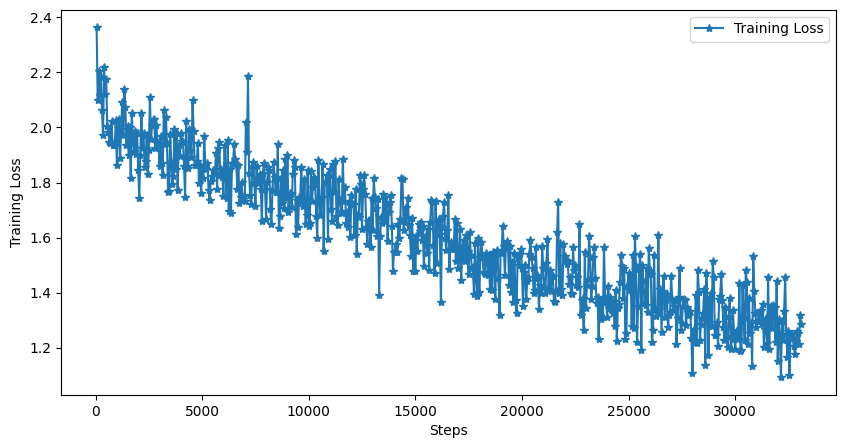

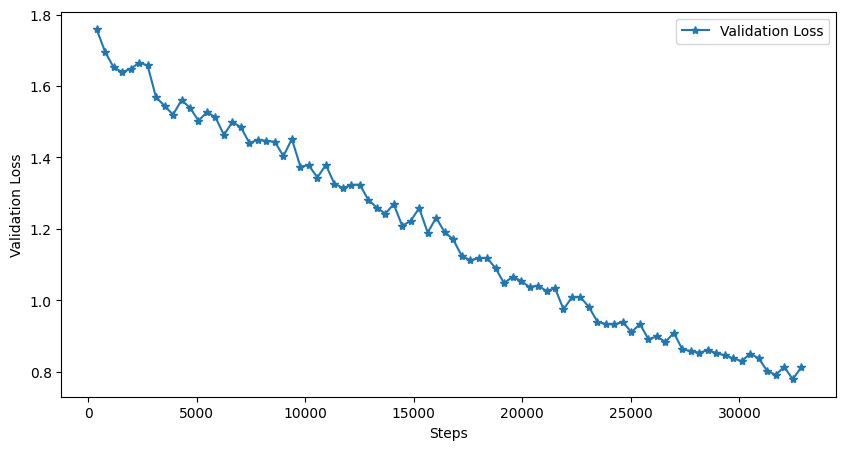

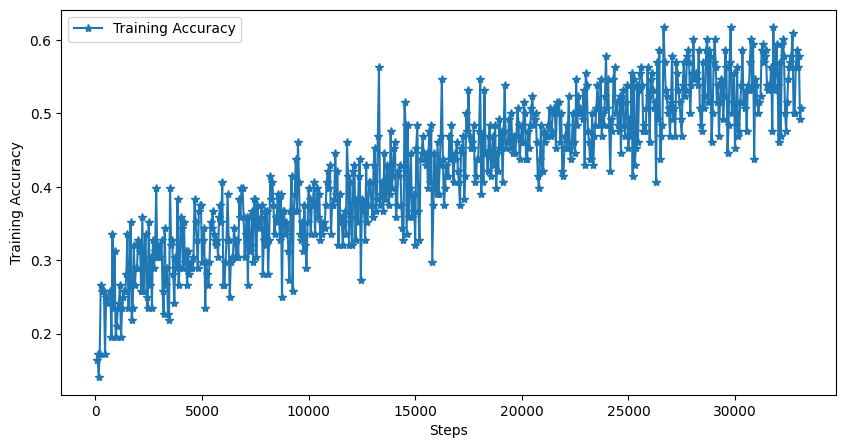

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Path to the TensorBoard log file
log_file = "/content/data/lightning/lightning_logs/version_1/events.out.tfevents.1699469183.16999e707a02.1051.1"

# Initialize dictionaries to hold the parsed data
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Iterate over the events in the log file
for e in tf.compat.v1.train.summary_iterator(log_file):
    for v in e.summary.value:
        if v.tag == 'train_loss':
            train_loss.append((e.step, v.simple_value))
        elif v.tag == 'val_loss':
            val_loss.append((e.step, v.simple_value))
        elif v.tag == 'train_acc':
            train_acc.append((e.step, v.simple_value))
        elif v.tag == 'val_acc':
            val_acc.append((e.step, v.simple_value))

# Function to plot the metrics
def plot_metrics(metrics, title):
    steps = [x[0] for x in metrics]
    values = [x[1] for x in metrics]
    plt.figure(figsize=(10, 5))
    plt.plot(steps, values, label=title , marker="*")
    plt.xlabel('Steps')
    plt.ylabel(title)
    plt.legend()
    plt.show()

# Plot each metric
plot_metrics(train_loss, 'Training Loss')
plot_metrics(val_loss, 'Validation Loss')
plot_metrics(train_acc, 'Training Accuracy')